In [16]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', facecolor='w')
plt.rc('font', size=11)

In [17]:
df = pd.read_fwf('data/features_full_100ns_ca.dat', widths=(6,3,9,) + (13,) * 32)
LAST_CLOSED = len(df) // 2
BLOCK = len(df) // 2

In [18]:
ang_column_map = {f'{ang}:{i}':f'{ang}_{i+1}' 
                  for ang in ('phi', 'psi') for i in range(175,189)}
df.rename(columns=ang_column_map, inplace=True)

In [19]:
def block_to_continuous(block):
    result = block[:1]
    ref = result[0]
    ref = 1000
    for value in block:
        if abs(value) < ref:
            ref = value
    for value in block[1:]:
        diff = value - ref
        result.append(value - 360 * round(diff / 360))
    return result

def block_to_continuous(block):
    data = np.array(block)
    max_density_value = np.mean(data)
    return list(data - 360 * np.round((data - max_density_value) / 360))
    

def ang_to_continuous(values):
    result = []
    for i in range(len(values) // BLOCK):
        result.extend(block_to_continuous(values[BLOCK * i: BLOCK * (i+1)]))
    return result

In [20]:
for column in df.columns[5:]:
    df[column] = ang_to_continuous(list(df[column]))

In [21]:
df_closed = df.iloc[:LAST_CLOSED,:]
df_open = df.iloc[LAST_CLOSED:,:]

In [22]:
all_cols = list(df.columns)
fig1_cols = all_cols[9:-2] + all_cols[3:5]

In [23]:
flat_df = df.melt(id_vars='state', value_vars=fig1_cols)
flat_df_deg = df.melt(id_vars='state', value_vars=fig1_cols[:-2])
flat_df_dist = df.melt(id_vars='state', value_vars=fig1_cols[-2:])

In [24]:
patch_color = '#FFFFCC'
grid_color = '#AAAAAA'

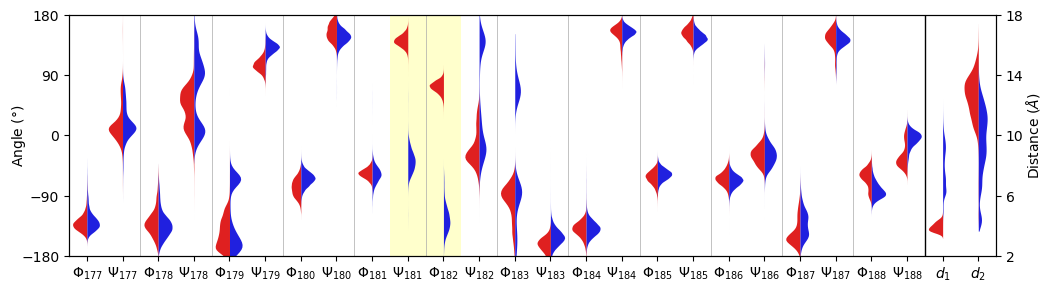

In [25]:
def plot_fig2(ax):
    
    sns.violinplot(x='variable', y='value', hue='state', data=flat_df_deg, split=True, 
                   inner=None, ax=ax, cut=0, palette=['red', 'blue'], linewidth=0.)
    # sns.violinplot(x='variable', y='value', hue='state', data=flat_fig1_deg, split=True, 
    #                inner=None, ax=ax, cut=0, palette=['red', 'blue', 'white'], linewidth=0.)
    ax.get_legend().remove()


    patch = mpl.patches.Rectangle((8.5, -180), 2, 360, 
                                  facecolor=patch_color, 
                                  lw=0, clip_on=False, zorder=-1)
    ax.add_patch(patch)

    labels = [f'${ang}_{{{i+1}}}$' for i in range(176, 188) for ang in ('\Phi', '\Psi') ] + ['$d_1$', '$d_2$']
    ax.set_xlim(-0.5, len(labels) - 0.5)
    ax.set_xticks(range(len(labels)))
    # ax.set_xlim(1.5, len(labels) + 1.5)
    # ax.set_xticks(range(2, len(labels) + 2))
    ax.set_xticklabels(labels)
    ax.set_xlabel(None)
    ax.set_ylabel('Angle ($\degree$)', labelpad=-5)
    ax.set_ylim((-180, 180))
    ax.set_yticks((-180, -90, 0, 90, 180))
    
    for i in range(1, len(labels), 2):
        ax.axvline(i+0.5, -180, 180, c=grid_color, lw=0.5)
    ax.set_axisbelow(True)
    
    ax2 = ax.twinx()
    sns.violinplot(x='variable', y='value', hue='state', data=flat_df_dist, split=True, inner=None, ax=ax2, 
                   cut=0, palette=['red', 'blue'], linewidth=0., order=labels[:-2] + ['CC_closed', 'CC_open'])
    ax2.get_legend().remove()        
    
    # ax2.set_xticks(range(-26, 2))
    ax2.set_xticklabels(labels)
    # ax2.set_xlim(-26, 2)
    ax2.set_ylabel('Distance ($\AA$)', labelpad=0)
    ax2.set_ylim((2, 18))
    ax2.set_yticks((2, 6, 10, 14, 18))    
    
    ax.axvline(23.5, -180, 180, c='black', lw=1.0)


sns.reset_orig()
fig, ax = plt.subplots(figsize=(10, 3))
fig.tight_layout()
plot_fig2(ax)
plt.savefig('Fig2.png', dpi=300, bbox_inches='tight')
plt.show()